In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from sklearn import preprocessing

In [14]:
doc = pd.read_csv('doc_reports.csv')
facial = pd.read_csv('facial_similarity_reports.csv')

# convert created_at to datetime
doc['created_at'] = pd.to_datetime(doc['created_at'])
facial['created_at'] = pd.to_datetime(facial['created_at'])

#Custom Function for normalizing numeric values between 0.0-1.0
def minmax_norm(df):
    return (df - df.min()) / ( df.max() - df.min())

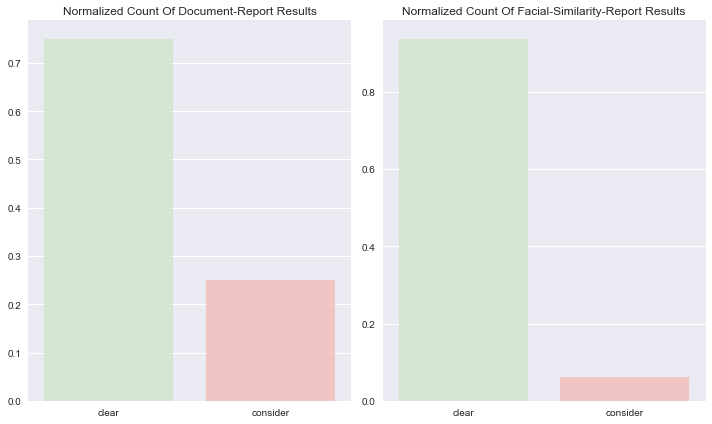

Doc_count: clear       0.750561
consider    0.249439
Name: result, dtype: float64, 
facial_count: clear       0.938108
consider    0.061886
NaN         0.000006
Name: result, dtype: float64


In [15]:
doc_count = doc['result'].value_counts(dropna=False, normalize=True)

custom_palette = ['#CCEBC5','#FBB4AE']
sns.set_palette(custom_palette)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title('Normalized Count Of Document-Report Results')
sns.barplot(x= doc_count.index, y = doc_count.values, alpha=0.8)
plt.tight_layout()

facial_count = facial['result'].value_counts(dropna=False, normalize=True)
plt.subplot(1,2,2)
plt.title('Normalized Count Of Facial-Similarity-Report Results')
sns.barplot(x = facial_count.index, y = facial_count.values, alpha=0.8)


plt.tight_layout()
plt.show()
plt.close()

print(f'Doc_count: {doc_count}, \nfacial_count: {facial_count}')

## 1.Check Overall Verification Success Rate


In [18]:
df_merged = pd.merge(doc, facial, how='inner', on = ['user_id', 'attempt_id'])
df_merged['created_at_x'] = pd.to_datetime(df_merged['created_at_x'])

customers_clear = df_merged[(df_merged['result_x'] ==  'clear') & (df_merged['result_y']== 'clear')].groupby(pd.Grouper(key='created_at_x', freq='W'))['result_x'].count().reset_index(name='count')

df_merged_full = df_merged.groupby(pd.Grouper(key='created_at_x', freq='W'))['result_x'].count().reset_index(name='count')

customers_clear['clear_rate'] = customers_clear['count'] / df_merged_full['count']


created_at = customers_clear['created_at_x']
count = customers_clear['clear_rate']

plt.style.use('seaborn')
plt.plot_date(x = created_at, y = count, linestyle='solid', label='clear')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title('Overall Verification Success Rate (weekly)', fontsize=15)

plt.show()


## 2. Check Wether The Facial Or Document Check Caused The Dip

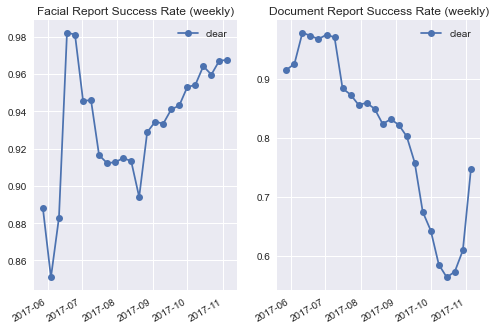

In [ ]:
#########
#Facial Report Clear Rate
#########
facial_result = facial[facial['result'] == 'clear']
facial_full = facial.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp = facial_result.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp.sort_values(by=['created_at'], inplace=True)

temp['clear_rate'] = temp['count'] / facial_full['count']
created_at = temp['created_at']
count = temp['clear_rate']

plt.subplot(1,2,1)
plt.style.use('seaborn')
plt.plot_date(created_at, count, linestyle='solid', label='clear')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title('Facial Report Success Rate (weekly)')

#########
#Document Report Clear Rate
#########

doc_result = doc[doc['result'] == 'clear']
doc_full = doc.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp = doc_result.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp.sort_values(by=['created_at'], inplace=True)

temp['clear_rate'] = temp['count'] / doc_full['count']
created_at = temp['created_at']
count = temp['clear_rate']

plt.subplot(1,2,2)
plt.style.use('seaborn')
plt.plot_date(created_at, count, linestyle='solid', label='clear')
plt.legend()
plt.gcf().autofmt_xdate()
plt.title('Document Report Success Rate (weekly)')

plt.show()

In [ ]:
### 1.1 Show that the Document Report Success Rate Curve is Basically the same to the Overall Success Rate. This leads us to the assumption that there is a causal relationship between the Document Verfification Check and the Overall KYC Outcome.

Text(0.5, 1.0, 'Document Report Success Rate (weekly)')

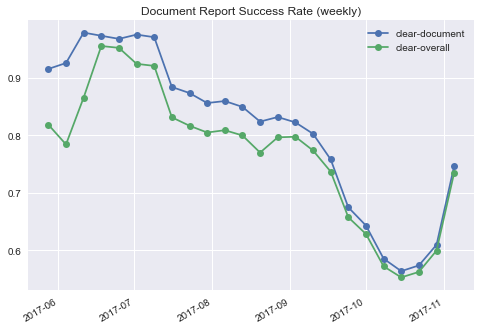

In [ ]:
doc_result = doc[doc['result'] == 'clear']
doc_full = doc.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp = doc_result.groupby(pd.Grouper(key='created_at', freq='W'))['result'].count().reset_index(name='count')
temp.sort_values(by=['created_at'], inplace=True)

temp['clear_rate'] = temp['count'] / doc_full['count']
created_at = temp['created_at']
count = temp['clear_rate']

plt.style.use('seaborn')
plt.plot_date(created_at, count, linestyle='solid', label='clear-document')

df_merged = pd.merge(doc, facial, how='inner', on = ['user_id', 'attempt_id'])
df_merged['created_at_x'] = pd.to_datetime(df_merged['created_at_x'])

customers_clear = df_merged[(df_merged['result_x'] ==  'clear') & (df_merged['result_y']== 'clear')].groupby(pd.Grouper(key='created_at_x', freq='W'))['result_x'].count().reset_index(name='count')

df_merged_full = df_merged.groupby(pd.Grouper(key='created_at_x', freq='W'))['result_x'].count().reset_index(name='count')

customers_clear['clear_rate'] = customers_clear['count'] / df_merged_full['count']

created_at = customers_clear['created_at_x']
count = customers_clear['clear_rate']

plt.plot_date(created_at, count, linestyle='solid', label='clear-overall')

plt.legend()
plt.gcf().autofmt_xdate()
plt.title('Document Report Success Rate (weekly)')

## From this point it is clear that the Document Check Caused the dip
Two anomalies can be observed in figure one. First, the low in June. Second, the abrupt change in trend from the end of July and the subsequent low persisting until mid-August. Since the fluctuations are only small compared to figure two, the causes of the two anomalies mentioned will not be investigated further.  Instead, figure two is identified as the cause of the error. Hence, the document report is examined in more depth for the root causes of the problem. 

## 3. The document report result can be divided into three sub-results: Rejected, Suspected, Caution 

The Sub-Reslts Caution and Suspected make up for about 95.6% of the failed Document Verifications. 
Since "Suspected" only causes a minor of 4.4% failed Document Verifications. The category "Suspected" is not being further investigated.

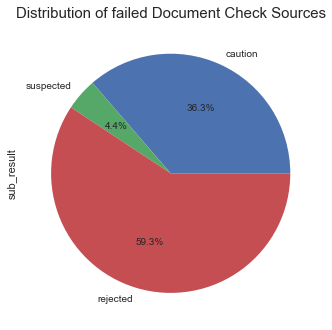

In [ ]:
plt.tight_layout()
plt.style.use('seaborn')
plt.title('Distribution of failed Document Check Sources', fontsize=15)
pie_chart = doc[doc['sub_result'] != 'clear'].groupby(pd.Grouper(key='sub_result'))['sub_result'].count().plot(kind='pie', y='sub_results',autopct='%1.1f%%')

In [10]:
document_marker = [
'visual_authenticity_result',
'image_integrity_result',
'face_detection_result', 
'supported_document_result',
'conclusive_document_quality_result',
'colour_picture_result',
'data_validation_result',
'data_consistency_result',
'data_comparison_result',
'police_record_result',
'compromised_document_result']

/Users/hakkarsama/.pyenv/versions/masterarbeit/lib/python3.8/site-packages/pandas/core/frame.py:4459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


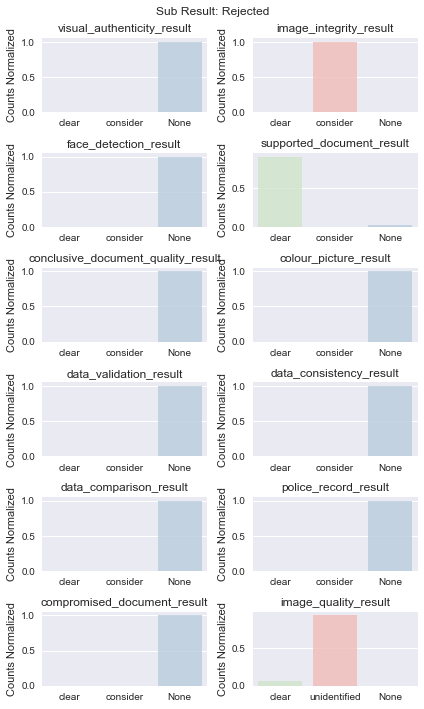

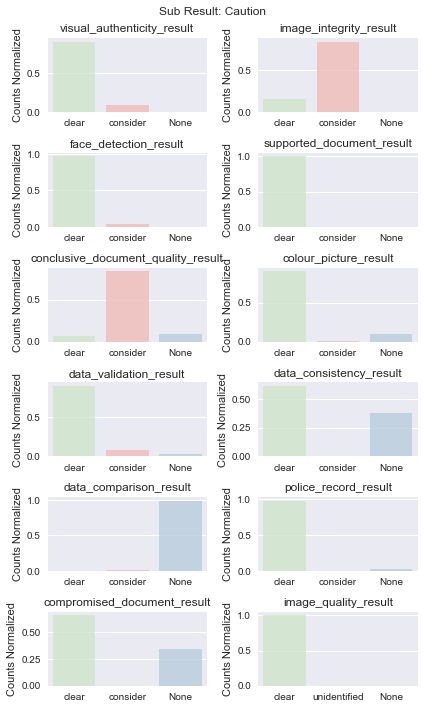

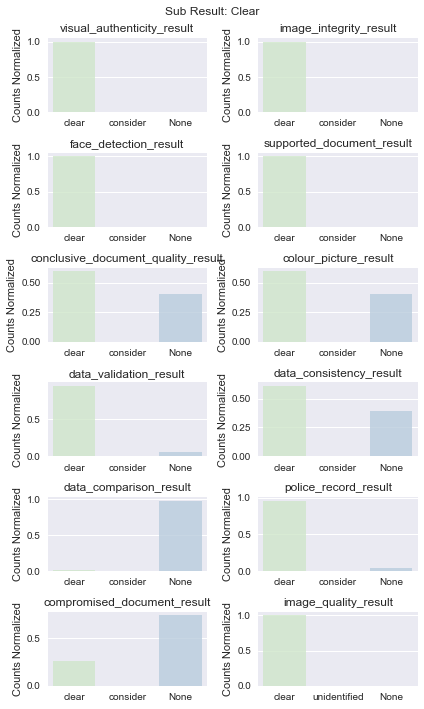

In [12]:
df1 = doc[doc['sub_result']=='rejected']
df2 = doc[doc['sub_result']=='caution']
df3 = doc[doc['sub_result']=='clear']

df1.fillna('None', inplace=True)
df2.fillna('None', inplace=True)
df3.fillna('None', inplace=True)

category_order = ['clear', 'consider', 'None']
custom_palette = ['#CCEBC5','#FBB4AE', '#B3CDE3']
category_order_visual_integrity = ['clear', 'unidentified', 'None']


temp = 1
plt.figure(figsize=(6,10))
for marker in document_marker:
    plt.subplot(6,2,temp)
    temp = temp + 1
    a = df1[marker].value_counts(normalize=True, dropna=False)
    sns.set_palette(custom_palette)
    sns.barplot(x = a.index, y = a.values, alpha=0.8, order=category_order)
    plt.title(marker)
    plt.ylabel('Counts Normalized')

plt.subplot(6,2,12)
a = df1['image_quality_result'].value_counts(normalize=True, dropna=False)
sns.barplot(x = a.index, y = a.values, alpha=0.8, order=category_order_visual_integrity)
sns.set_palette(custom_palette)
plt.title('image_quality_result')
plt.ylabel('Counts Normalized')

plt.suptitle('Sub Result: Rejected', fontsize=12)
plt.tight_layout()
plt.show()

#######
plt.figure(figsize=(6,10))
temp = 1
for marker in document_marker:
    plt.subplot(6,2,temp)
    temp = temp + 1
    a = df2[marker].value_counts(normalize=True, dropna=False)
    sns.barplot(x = a.index, y = a.values, alpha=0.8, order=category_order)
    plt.title(marker)
    plt.ylabel('Counts Normalized')

plt.subplot(6,2,temp)
a = df2['image_quality_result'].value_counts(normalize=True, dropna=False)
sns.barplot(x= a.index, y= a.values, alpha=0.8, order=category_order_visual_integrity)
sns.set_palette(custom_palette)
plt.title('image_quality_result')
plt.ylabel('Counts Normalized')

plt.suptitle('Sub Result: Caution', fontsize=12)
plt.tight_layout()
plt.show()

#########
plt.figure(figsize=(6,10))
temp = 1
for marker in document_marker:
    plt.subplot(6,2,temp)
    temp = temp + 1
    a = df3[marker].value_counts(normalize=True, dropna=False)
    sns.barplot(x = a.index, y = a.values,alpha=0.8, order=category_order)
    plt.title(marker)
    plt.ylabel('Counts Normalized')

plt.subplot(6,2,temp)
a = df3['image_quality_result'].value_counts(normalize=True, dropna=False)
sns.barplot(x = a.index, y = a.values, alpha=0.8, order=category_order_visual_integrity)
sns.set_palette(custom_palette)
plt.title('image_quality_result')
plt.ylabel('Counts Normalized')

plt.suptitle('Sub Result: Clear', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()